### Importando

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import time

### Defining constants

In [2]:
G = 6.67428e-11

AU = (149.6e9)
SCALE = 300/AU

### The body class

In [3]:
class Body:
    ## All vectors are decomposed in x-axis and y-axis
    ## p = (x,y) -> Actual Position Vector
    ## v = (x,y) -> Actual Velocity Vector
    ## pos_x -> List of all x-axis positions over time
    ## pos_y -> List of all y-axis positions over time
    ## color -> Orbit trace and planet color
    
    def __init__(self, name_of = 'UNNAMED', color_of = 'gray'):
        self.name = name_of
        self.color = color_of
        
    
    mass = 0
    v_x = v_y = v_x0 = v_y0 = 0
    p_x = p_y = p_x0 = p_y0 = 0
    pos_x = []
    pos_y = []
    theta = 0
    kinetic = 0
    potential = 0
    
    def acceleration(self, bodies, pos = [0,0], retangle = False):
        acc_x = acc_y = 0
        t = -5
        for other in bodies:
            if self is other:
                continue
            d_x = (other.p_x - pos[0])
            d_y = (other.p_y - pos[1])
            d = math.sqrt(d_x**2 + d_y**2) ## Calculate the distance between the bodies
            if d == 0:
                raise ValueError('The bodies %r and %r collided' %(self.name, other.name))

            ## Compute acceleration OTHER causes on THIS
            acc = G * other.mass / d**2

            ## Decomposing the acceleration on x-axis and y-axis
            theta = math.atan2(d_y, d_x)
            a_x = acc*math.cos(theta)
            a_y = acc*math.sin(theta)
            if other.name == 'Sun':
                t = theta
            acc_x += a_x
            acc_y += a_y
        if retangle:
            return acc_x, acc_y, t
        else:
            return acc_x, acc_y
        
    def potential_energy(self, bodies):
        energy = 0
        for other in bodies:
            if self is other:
                continue
            d_x = (other.p_x - self.p_x)
            d_y = (other.p_y - self.p_y)
            d = math.sqrt(d_x**2 + d_y**2) ## Calculate the distance between the bodies
            if d == 0:
                raise ValueError('The bodies %r and %r collided' %(self.name, other.name))

            ## Compute acceleration OTHER causes on THIS
            p_e = G * other.mass * self.mass / d
            energy += p_e
        return -energy
    
    def kinetic_energy(self):
        velocity = (self.v_x**2 + self.v_y**2) # Velocity^2
        return 1/2 * self.mass * velocity

### Simulation

In [4]:
def simulate(bodies, step = 1, period = 365, method = 'euler'):
    count = 0
    pos = {}
    angle = {}
    pot_energy = {}
    kin_energy = {}
    for body in bodies:
        pos[body.name] = []
        angle[body.name] = []
        pot_energy[body.name] = []
        kin_energy[body.name] = []
        ## Routine that resets body position state in each simulation
        body.p_x = body.p_x0
        body.p_y = body.p_y0
        body.v_x = body.v_x0
        body.v_y = body.v_y0
        
    while count < period:
        acc = {}
        for body in bodies:
            acc_x = acc_y = 0
            for other in bodies:
                if body is other:
                    continue
                acc_x, acc_y, theta_body = body.acceleration(bodies, pos = [body.p_x, body.p_y], retangle = True)
                acc[body] = (acc_x, acc_y)
                body.angle = theta_body
                body.potential = body.potential_energy(bodies)
                body.kinetic = body.kinetic_energy()

        for body in bodies:
            pos[body.name].append((body.p_x,body.p_y))
            angle[body.name].append(body.angle)
            pot_energy[body.name].append(body.potential)
            kin_energy[body.name].append(body.kinetic)
            
            a_x, a_y = acc[body]
            
            if method == 'euler-cromer':
            ## Sympletic 1st-order Euler
                body.v_x += a_x * step
                body.v_y += a_y * step

                body.p_x += body.v_x * step
                body.p_y += body.v_y * step
            elif method == 'rk4':
            ## Runge-kutta 4th-order
                k1_x = step * body.v_x
                k1_y = step * body.v_y
                k1_vx = step * a_x
                k1_vy = step * a_y
                
                ax_new, ay_new = body.acceleration(bodies, pos = [body.p_x + k1_x/2, body.p_y + k1_y/2])
                
                vhalf_x = body.v_x + 0.5 * step * ax_new
                vhalf_y = body.v_y + 0.5 * step * ay_new
                
                k2_x = step * vhalf_x
                k2_y = step * vhalf_y
                k2_vx = step * ax_new
                k2_vy = step * ay_new
                
                ax_new, ay_new = body.acceleration(bodies, pos = [body.p_x + k2_x/2, body.p_y + k2_y/2])
                
                vhalf_x = body.v_x + 0.5 * step * ax_new
                vhalf_y = body.v_y + 0.5 * step * ay_new
                
                k3_x = step * vhalf_x
                k3_y = step * vhalf_y
                k3_vx = step *  ax_new
                k3_vy = step *  ay_new
                
                ax_new, ay_new = body.acceleration(bodies, pos = [body.p_x + k3_x, body.p_y + k3_y])
                
                vhalf_x = body.v_x + step * ax_new
                vhalf_y = body.v_y + step * ay_new
                
                k4_x = step * vhalf_x
                k4_y = step * vhalf_y
                k4_vx = step * ax_new
                k4_vy = step * ay_new
                
                body.p_x += (k1_x + 2*(k2_x + k3_x)+ k4_x)/6 
                body.p_y += (k1_y + 2*(k2_y + k3_y)+ k4_y)/6
                body.v_x += (k1_vx + 2*(k2_vx + k3_vx)+ k4_vx)/6 
                body.v_y += (k1_vy + 2*(k2_vy + k3_vy)+ k4_vy)/6
                
                
            elif method == 'verlet':
            ## Velocity Verlet / Leapfrog - Sympletic 2nd-order methods
                vhalf_x = body.v_x +  0.5 * step * a_x
                vhalf_y = body.v_y +  0.5 * step * a_y
                
                body.p_x += vhalf_x * step
                body.p_y += vhalf_y * step
                
                ax_new, ay_new = body.acceleration(bodies, pos = [body.p_x, body.p_y])
                
                body.v_x = vhalf_x + ax_new * 0.5 * step
                body.v_y = vhalf_y + ay_new * 0.5 * step
            
            else:
            ## 1st-order Euler
                body.p_x += body.v_x * step
                body.p_y += body.v_y * step
                
                body.v_x += a_x * step
                body.v_y += a_y * step
        count += 1
    return pos, angle, pot_energy, kin_energy

### Plotter

In [5]:
def orbit_plotter(pos, bodies, title = 'Orbits', scale = False):
    for b in bodies:
        b.pos_x = [i[0] for i in pos[b.name]]
        b.pos_y = [i[1] for i in pos[b.name]]
    
    plt.figure(figsize=(10,10))
    
    for b in bodies:
        plt.plot(b.pos_x, b.pos_y, label = b.name, color = b.color, linestyle=':' )
        plt.scatter(b.pos_x[-1],b.pos_y[-1], color = b.color)
    
    plt.legend()
    plt.grid(alpha=0.2)

    
    ax = plt.gca()
    ax.set_facecolor('black')
    
    plt.xlabel('Latitudinal distance in AU')
    plt.ylabel('Longitudinal distance in AU')
        
    plt.title(title)
    plt.show()
    return ax

In [6]:
np.sqrt(G/1)

8.16962667445704e-06

In [7]:
sun = Body('Sun', 'yellow')
sun.mass = 1.98892e30
sun.size = 20

earth = Body('Earth', 'blue')
earth.mass = 5.9742e24
earth.p_x0 = -1*AU
earth.v_y0 = 29.783e3
earth.size = 1

venus = Body('Venus', 'pink')
venus.mass = 4.8685e24
venus.p_x0 = 0.723 * AU
venus.v_y0 = -35.02e3
venus.size = 0.95
    
mercury = Body('Mercury', 'purple')
mercury.mass = 0.3e24
mercury.p_x0 = 0.387 * AU
mercury.v_y0 = 47.7e3
mercury.size = 0.38
    
mars = Body('Mars', 'red')
mars.mass = 0.642e24
mars.p_x0 = 1.405 * AU
mars.v_y0 = 24.1e3
mars.size = 0.53
    
jupiter = Body('Jupiter', 'orange')
jupiter.mass = 1.898e27
jupiter.p_x0 = 5.20 * AU
jupiter.v_y0 = 13.1e3
jupiter.size = 11.2
    
saturn = Body('Saturn', 'brown')
saturn.mass = 5.68e26
saturn.p_x0 = 9.58 * AU
saturn.v_y0 = 9.7e3
saturn.size = 9.45
    
uranus = Body('Uranus', 'green')
uranus.mass = 8.6e25
uranus.p_x0 = 19.20 * AU
uranus.v_y0 = 6.8e3
uranus.size = 4
    
neptune = Body('Neptune', 'dodgerblue')
neptune.mass = 1.02e26
neptune.p_x0 = 30.05 * AU
neptune.v_y0 = 5.4e3
neptune.size = 3.8
    
halley = Body('Halley', 'white')
halley.mass = 1.02e14
halley.p_x0 = 35 * AU
halley.v_y0 = 1e3

pluto = Body('Pluto', 'purple')
pluto.mass = 0.0146e24
pluto.p_x0 = 39.48 * AU
pluto.v_y0 = 4.7e3

In [8]:
1/2*(0.64e24)*(24.1e3)**2

1.858592e+32

### Full Solar System

In [13]:
bodies = [sun, earth, venus, mars, mercury, jupiter, saturn, neptune, uranus, pluto, halley]
bodies_plot = [sun, earth, venus, mars, halley]

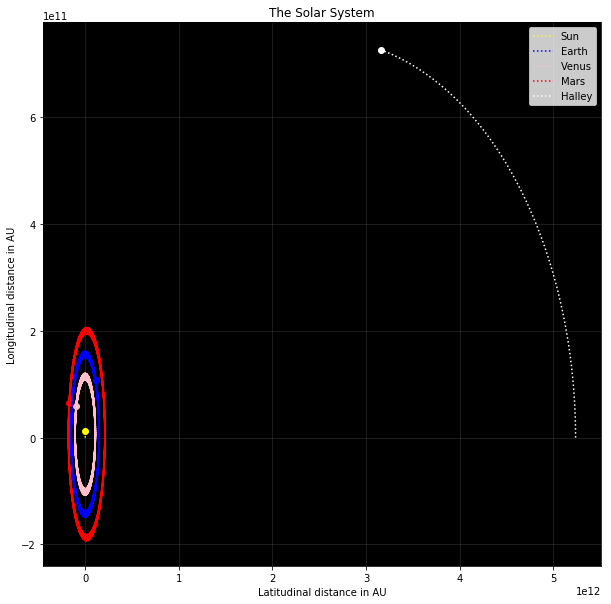

In [16]:
pl = orbit_plotter(pos, bodies_plot, title='The Solar System')

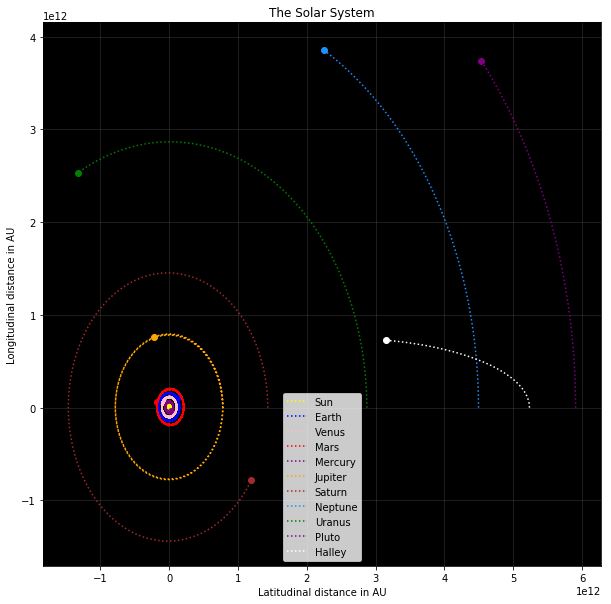

A simulação foi feita em 17.833698272705078 segundos


In [15]:
start_time = time.time()
pos, angle, pe, ke = simulate(bodies, period = 10000, method='verlet', step = 24*3600)
pl = orbit_plotter(pos, bodies, title='The Solar System')
end_time = time.time()
print('A simulação foi feita em %s segundos' % (end_time - start_time))

In [12]:
pe['Venus']

[-5.976214649246619e+33,
 -5.9762157954916e+33,
 -5.97621923848601e+33,
 -5.976224988376173e+33,
 -5.976233055781889e+33,
 -5.97624344756989e+33,
 -5.976256165351822e+33,
 -5.976271205882531e+33,
 -5.976288562091497e+33,
 -5.976308224028106e+33,
 -5.9763301795142e+33,
 -5.976354414531794e+33,
 -5.97638091342999e+33,
 -5.976409659024065e+33,
 -5.976440632635586e+33,
 -5.97647381410262e+33,
 -5.976509181776091e+33,
 -5.976546712510694e+33,
 -5.976586381654661e+33,
 -5.976628163040326e+33,
 -5.976672028976401e+33,
 -5.976717950242356e+33,
 -5.976765896084992e+33,
 -5.976815834217228e+33,
 -5.976867730819162e+33,
 -5.976921550541358e+33,
 -5.97697725651038e+33,
 -5.97703481033663e+33,
 -5.977094172124467e+33,
 -5.977155300484638e+33,
 -5.977218152549067e+33,
 -5.977282683987974e+33,
 -5.97734884902939e+33,
 -5.977416600481013e+33,
 -5.977485889754469e+33,
 -5.977556666891918e+33,
 -5.977628880595081e+33,
 -5.977702478256614e+33,
 -5.977777405993897e+33,
 -5.977853608685229e+33,
 -5.9779310

In [ ]:
dx = sun.p_x - earth.p_x
dy = sun.p_y - earth.p_y
dx2 = sun.pos[50] - earth.p_x[50]
dy2 = sun.p_y[50] - earth.p_y[50]
pe = -earth.mass * G / (dy2**2+dx2**2)**(1/2)
pe2 = -earth.mass * G / (dy2**2+dx2**2)**(1/2)

In [ ]:
pos = simulate(bodies, period = 100, method='euler-cromer', step = 0.01)
pl = orbit_plotter(pos, bodies_plot, title='The Solar System')

In [ ]:
angle['Earth']

In [ ]:
pl.lines[1].get_data()

In [ ]:
prox0 = [abs(i) < 1e8 for i in pl.lines[1].get_data()[1]]
prox0.count(True)

In [ ]:
print(pl.lines[8].get_data()[1])

### Halley

In [ ]:
comet = [sun, halley]
pos = simulate(comet, step = 1, period = 27740)
orbit_plotter(pos, comet, title="Halley's Comet Orbit")

In [ ]:
a = zip(halley.pos_x,halley.pos_y)
for i in a:
    if abs(i[1]) == 0:
        print(i)


## Solar System with Halley

In [ ]:
bodies = [sun, earth, venus, mercury, mars]
bodies_plot = [sun, earth, venus, mercury, mars]
    
pos = simulate(bodies, period = 225, step = 1)
pl = orbit_plotter(pos, bodies_plot, title='The Solar System',scale = True)

In [ ]:
[abs(i) < 0.05e11 for i in venus.pos_y]

In [ ]:
1.495e11,0.3e11

### Inner Solar System

In [ ]:
bodies = [sun, earth, venus, mercury, mars, jupiter, saturn, neptune, uranus, halley]
bodies_plot = [sun, earth, venus, mercury, mars]
    
pos = simulate(bodies, period = 225)
orbit_plotter(pos, bodies_plot, title='The Solar System')

In [ ]:
3600*24

---

## Mudança de dimensões

---

In [ ]:
# G = 6.67428e-11
solar_mass = 1.98892e30
G = 4*math.pi**2

AU = (149.6e9)
SCALE = 300/AU
period = 20000

class Body:
    ## All vectors are decomposed in x-axis and y-axis
    ## p = (x,y) -> Actual Position Vector
    ## v = (x,y) -> Actual Velocity Vector
    ## pos_x -> List of all x-axis positions over time
    ## pos_y -> List of all y-axis positions over time
    ## color -> Orbit trace and planet color
    
    def __init__(self, name_of = 'UNNAMED', color_of = 'gray'):
        self.name = name_of
        self.color = color_of
    
    mass = 0
    v_x = v_y = 0 ## A
    p_x = p_y = 0
    pos_x = []
    pos_y = []
    
    def acceleration(self, other):
        
        if self is other:
            raise ValueError("Attraction of object %r to itself requested"
                             % self.name)
        
        d_x = (other.p_x - self.p_x)
        d_y = (other.p_y - self.p_y)
        d = math.sqrt(d_x**2 + d_y**2) ## Calculate the distance between the bodies
        if d == 0:
            raise ValueError('The bodies %r and %r collided' %(self.name, other.name))
            
        ## Compute acceleration OTHER causes on THIS
        acc = G * self.mass * other.mass / d**2
        
        ## Decomposing the acceleration on x-axis and y-axis
        theta = math.atan2(d_y, d_x)
        a_x = acc*math.cos(theta)
        a_y = acc*math.sin(theta)
        return a_x, a_y
    
def simulate(bodies, days_step = 1):
    step = 1 # Total of seconds for each step: 24*3600 = one day
    count = 0
    pos = {}
    for body in bodies:
        pos[body.name] = []
        
    while count < period:
        acc = {}
        for body in bodies:
            acc_x = acc_y = 0
            for other in bodies:
                if body is other:
                    continue
                a_x, a_y = body.acceleration(other)
                acc_x += a_x
                acc_y += a_y
            acc[body] = (acc_x, acc_y)

        for body in bodies:
            a_x, a_y = acc[body]

            body.v_x += a_x * step
            body.v_y += a_y * step

            body.p_x += body.v_x * step
            body.p_y += body.v_y * step
            
            pos[body.name].append((body.p_x,body.p_y))
        count += 1
    return pos

def orbit_plotter(pos, bodies):
    for b in bodies:
        b.pos_x = [i[0] for i in pos[b.name]]
        b.pos_y = [i[1] for i in pos[b.name]]
    
    plt.figure(figsize=(10,10))
    
    for b in bodies:
        plt.plot(b.pos_x, b.pos_y, label = b.name, color = b.color, linestyle=':' )
        plt.scatter(b.pos_x[-1],b.pos_y[-1], color = b.color)
    
    plt.legend()
    plt.grid(alpha=0.2)
    plt.xlabel('Latitudinal distance in AU')
    plt.ylabel('Longitudinal distance in AU')
    ax = plt.gca()
    ax.set_facecolor('black')
    plt.show()

In [ ]:
def main():
    solar_mass = 1.98892e30
    AU_yr = 4.74371736111
    
    sun = Body('Sun', 'yellow')
    sun.mass = 1

    earth = Body('Earth', 'blue')
    earth.mass = 5.9742e24/solar_mass
    earth.p_x = -1
    earth.v_y = 2*math.pi        # 29.783 km/sec

    # Venus parameters taken from
    # http://nssdc.gsfc.nasa.gov/planetary/factsheet/venusfact.html
    venus = Body('Venus', 'pink')
    venus.mass = 4.8685e24/solar_mass
    venus.p_x = 0.723
    venus.v_y = 3*math.pi
    
    mercury = Body('Mercury', 'purple')
    mercury.mass = 3e25/solar_mass
    mercury.p_x = 0.49
    mercury.v_y = 47.7 / AU_yr
    
    mars = Body('Mars', 'red')
    mars.mass = 6.42e25/solar_mass
    mars.p_x = 1.405
    mars.v_y = 24.1 / AU_yr
    
    jupiter = Body('Jupiter', 'orange')
    jupiter.mass = 1.898e27/solar_mass
    jupiter.p_x = 5.20
    jupiter.v_y = 13.1 / AU_yr
    
    saturn = Body('Saturn', 'brown')
    saturn.mass = 5.68e26/solar_mass
    saturn.p_x = 9.58
    saturn.v_y = 9.7 / AU_yr
    
    uranus = Body('Uranus', 'green')
    uranus.mass = 8.6e25/solar_mass
    uranus.p_x = 19.20
    uranus.v_y = 6.8 / AU_yr
    
    neptune = Body('Neptune', 'dodgerblue')
    neptune.mass = 1.02e26/solar_mass
    neptune.p_x = 30.05
    neptune.v_y = 5.4 / AU_yr
    
    
    bodies = [sun, earth, venus, mercury]
    pos = simulate(bodies, 1)

    orbit_plotter(pos, bodies)
    
if __name__ == '__main__':
    main()    

In [ ]:
sun_m = 1.989e30

1.898e27/sun_m

In [ ]:
1/1047

In [ ]:
3600*24*30*12

In [ ]:
29.783 / 1.496e8

In [ ]:
29.783/4.74371736111


In [ ]:
4*math.pi**2


In [ ]:
ano = 3.154e7

In [ ]:
terra = 5.972e24

In [ ]:
AU**3 * (1/terra) * (1/ano)